2024.01.08  
Remove the protected variables from the model to see the change of predicting power and influence in fariness.

2024.01.04  
Lock the code chunk for random grid search for RF, XGB, and use the target parameters directly to save running time.  
Save the result from NN models and load the NN data to draw ROC curve at the end of this scripts.

2024.01.01  
The correct method is to separate the dataset first, do the data imuptation, and then convert the data into dummy coding.  
Only the linear models GLM-family including the ridge regression and Lasso regression need to set one level as reference.  
Finally, I decided to use the R do the PMM data impuation, the file is `50_Data_cleaning_V7.R`

2023.12.31  
Using the unimputed dataset, and split the dataset first, and then do the imputation separately.  
All changes will have a comment with date 2023.12.31

2023.11.09  
To ensure all models are trained on the same training dataset and test on the same test dataset. The machine learning will use the NN dataset separation methods

This file is to replicate the R models  
2023.10.30. This file is based on the 38 file. Just added the 8 the grade math score, students and parent's expectations into the model 
The target is to revisit the machine leanring method to find the best predictive model and also evaluate the algorithmic fairness by using DAF.

## 1.0 Import the packages

[2024.01.01]  
The `fancyimpute` package can not be installed through `pip install` or `conda install`. Instead, use `conda install -c conda-forge fancyimpute`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score,classification_report,\
    confusion_matrix,roc_curve,accuracy_score,precision_score,recall_score,f1_score, matthews_corrcoef
# 2024.01.01 import the package for imputing missing values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from fancyimpute import IterativeImputer as MICE
# import the prepossessing package
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,LabelEncoder
from xgboost import XGBClassifier
# import the SMOTE package
from imblearn.over_sampling import SMOTE, ADASYN,BorderlineSMOTE,SVMSMOTE
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

## 2.0 Data cleaning 2023.10.23

In [2]:
# load the impueted training and testing dataset
train = pd.read_csv('~/Desktop/PhD_Learning/Independent Studies/dropout/01_data/02_processed_data/25_train_0101_imputed_pmm_nr_dropped.csv')
test = pd.read_csv('~/Desktop/PhD_Learning/Independent Studies/dropout/01_data/02_processed_data/25_test_0101_imputed_pmm_nr_dropped.csv')

In [3]:
train.shape, test.shape

((13865, 30), (3467, 30))

Here, to copy the train and test dataset is to use in the future analysis of fairness since it will use the procted vairables.

In [4]:
# copy this data for later use
variables_complete = ['X4EVERDROP', 'X1SEX', 'X1RACE', 'X1STAGE', 'X1CONTROL',
       'X1SES_U', 'X1SCHOOLENG', 'X1SCHOOLBEL', 'X1SCHOOLCLI', 'X1TXMTSCOR',
       'X1REGION', 'X1MTHID', 'X1MTHUTI', 'X1MTHEFF',
       'X1MTHINT', 'X1SCIID', 'X1SCIUTI', 'X1SCIEFF', 'X1SCIINT', 'X1PAREDEXPCT', 'X1STUEDEXPCT', 
       'X1PROBLEM', 'S1MSCORE']
train_copy = train[variables_complete]
test_copy = test[variables_complete]

NOTE: Need to consider whether to add the 9th grade's GPA into the variables

[2023.12.31]  
Use `False` to include all the necessary variables, since we need use all variables to do the data imputation and then considering whether to keep the dataset aware or blind.

In [5]:
# 2023.12.31: set false to include all variables.
drop_protected = True

[2023.12.31]  
The protected variables are `X1SEX` and `X1RACE`. The `X1SEX_U` is not considered as the protected variable.

In [6]:
if drop_protected == False:
    # select the interested columns
    variables = ['X4EVERDROP', 'X1SEX', 'X1RACE', 'X1STAGE', 'X1CONTROL',
       'X1SES_U', 'X1SCHOOLENG', 'X1SCHOOLBEL', 'X1SCHOOLCLI', 'X1TXMTSCOR',
       'X1REGION', 'X1MTHID', 'X1MTHUTI', 'X1MTHEFF',
       'X1MTHINT', 'X1SCIID', 'X1SCIUTI', 'X1SCIEFF', 'X1SCIINT', 'X1PAREDEXPCT', 'X1STUEDEXPCT', 
       'X1PROBLEM', 'S1MSCORE']
else:
    # 2023.10.23 drop the protected variables
    # select the interested columns
    variables = ['X4EVERDROP', 'X1STAGE', 'X1CONTROL',
       'X1SES_U', 'X1SCHOOLENG', 'X1SCHOOLBEL', 'X1SCHOOLCLI', 'X1TXMTSCOR',
       'X1REGION', 'X1MTHID', 'X1MTHUTI', 'X1MTHEFF',
       'X1MTHINT', 'X1SCIID', 'X1SCIUTI', 'X1SCIEFF', 'X1SCIINT', 'X1PAREDEXPCT', 'X1STUEDEXPCT', 
       'X1PROBLEM', 'S1MSCORE']
    
train = train[variables]
test = test[variables]

[2024.01.01]  
Conver the string columns into categorical variables

In [7]:
# select the columns that are categorical
categorical_features = train.select_dtypes(include=['object']).columns.tolist()
# extract the numerical variables
numerical_features = train.select_dtypes(include=['int64', 'float64']).columns.tolist()

### 2.1 Separate the data

In [8]:
# define the features and target
X_train = train.drop(['X4EVERDROP'], axis=1)
y_train = train['X4EVERDROP']
X_test = test.drop(['X4EVERDROP'], axis=1)
y_test = test['X4EVERDROP']

In [9]:
# check the shape of train and test dataset
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13865, 20) (3467, 20) (13865,) (3467,)


In [10]:
# check the race distribution PROPORATION
if drop_protected==False:
    X_train['X1RACE'].value_counts(normalize=True,dropna=False)

### 2.2 Data Imputation

[2024.01.01]  
The data imputation for the categorical variables is to first convert it into the ordinal variable, and in the mean time treat the missing level as a new numeric level. Then do the imputation and inversely decoding the ordinal levels into the categorical variables.  
Here, I write function that can be reused on the test dataset and training dataset.  

Finally, I choose to output the two csv file and send it into R using PMM method to do the imputation

[2023.12.31]  
Now, do the data imputation on the train and test dataset seprataly.  
The `IterativeImputer` function is like the PMM in R, by using the other columns as inputs to estimate a model to predict the missing in each certain columns.

[2024.01.01]   
Check the balance before and after impuation

In [11]:
# check the distribution of X1RACE in the X_train and X_test
if drop_protected == False:
    X_train['X1RACE'].value_counts(normalize=True,dropna=False)

In [12]:
if drop_protected == False:
    X_test['X1RACE'].value_counts(normalize=True,dropna=False)

### 2.3 Convert the categorical variabels into one-hot coding

In [13]:
# drop the meaningless and target columns
numerical_features.remove('X4EVERDROP')

[2024.01.01]  
The following code convert all the categorical variables into dummy codings

In [14]:
# covert the categorical variables to dummy variables
X_train = pd.get_dummies(X_train, columns=categorical_features)
# remove any specical signs like the -, /, and _ in the column names
new_names = {col: re.sub(r'[^A-Za-z0-9]+', '', col) for col in X_train.columns}
# rename the columns
X_train.columns = list(new_names.values())
# covert the categorical variables to dummy variables
X_test = pd.get_dummies(X_test, columns=categorical_features)
# remove any specical signs like the -, /, and _ in the column names
new_names = {col: re.sub(r'[^A-Za-z0-9]+', '', col) for col in X_test.columns}
X_test.columns = list(new_names.values())

## 3.0 Check the data balance

In [15]:
# check the balance of the target variable
# print the value counts of each class
print(y_train.value_counts())
# the argument `normalize=True` returns the relative frequencies of the unique values
print(y_train.value_counts(normalize=True))

0    11694
1     2171
Name: X4EVERDROP, dtype: int64
0    0.843419
1    0.156581
Name: X4EVERDROP, dtype: float64


The training dataset is obviously imbalanced with the ratio of undropped to dropped 8:1

In [16]:
# try BoarderlineSMOTE
X_train_blsm, y_train_blsm = BorderlineSMOTE(random_state=42).fit_resample(X_train, y_train)
# check the freq of target variable

print(y_train_blsm.value_counts())

0    11694
1    11694
Name: X4EVERDROP, dtype: int64


The training dataset is balanced.  
Later I will add the Borderline SMOTE and the other SMOTE variants.

In [17]:
# print the value count in the target variable in the testing set
print(y_test.value_counts())

0    2924
1     543
Name: X4EVERDROP, dtype: int64


## 4.0 Write functions to get the results

write a function to print all the results for each model

In [18]:
def get_outputs(model_name, y_true, y_predicted):
    print("The results of {} on are: \n".format(model_name))
    print(classification_report(y_true, y_predicted))
    print("The confusion matrix is: \n", confusion_matrix(y_true, y_predicted))
    print("The recall score is: ", recall_score(y_true, y_predicted))
    # print the accuracy score
    print("The accuracy score is: ", accuracy_score(y_true, y_predicted))
    # print the specificity score
    print("The specificity score is: ", recall_score(y_true, y_predicted, pos_label=0))
    print("The precision score is: ", precision_score(y_true, y_predicted))
    print("The f1 score is: ", f1_score(y_true, y_predicted), "\n")
    # print the matthews correlation coefficient
    print("The matthews correlation coefficient is: ", matthews_corrcoef(y_true, y_predicted))

Note, the confusion matrix that the sklearn return is in the following format  

[[TN, FN]  
[FN, TP]]

write a function to get the best F1-score and its best threshold

In [19]:
# define a function take the y_true and y_pred_prob as input and get the best threshold to maximize the f1 score
def get_best_threshold(y_true, y_pred_prob):
    best_thresh = None
    best_score = 0
    for thresh in np.arange(0.1, 1, 0.01):
        score = f1_score(y_true, np.array(y_pred_prob)>thresh)
        if score > best_score:
            best_thresh = thresh
            best_score = score
    print("The best f1 score is: ", best_score)
    print("The best threshold is: ", best_thresh)

Write a function to get the ROC curve

In [20]:
# write a function to plot the ROC curve, show best threshold along the curve, and print the AUC score on the plot
def plot_roc_curve(y_true, y_pred_prob, model_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=model_name)
    plt.plot([0,1], [0,1], color='red', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.title("ROC Curve")
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    print("The AUC score is: ", roc_auc_score(y_true, y_pred_prob))
    get_best_threshold(y_true, y_pred_prob)

## 5.0 Run the models

### 5.1 Logistic regression

#### 5.1.1 Fit the model on oversampled data

[20204.01.02]  
When fitting the logistic regression model, you need to drop one level of the one-hot coded vairables to avoid multicolinearity. 

In [21]:
# [2024.02.02]
# drop one of the dummy variables to avoid multicollinearity
if drop_protected == False:
    dropped_cols = ['X1CONTROLCatholicorotherprivate','X1REGIONMidwest','X1RACEWhitenonHispanic']
else:
    dropped_cols = ['X1CONTROLCatholicorotherprivate','X1REGIONMidwest']
X_train_blsm_logreg = X_train_blsm.copy()
X_train_blsm_logreg.drop(dropped_cols, axis=1, inplace=True)
X_test_logreg = X_test.copy()
X_test_logreg.drop(dropped_cols, axis=1, inplace=True)

In [22]:
# change the X1SES_U to X1SESU
numerical_features.remove('X1SES_U')
numerical_features.append('X1SESU')

In [23]:
# remove the X1SEX
if drop_protected == False:
    numerical_features.remove('X1SEX')

In [24]:
# [2024.02.02]  
# normalize the numerical features
scaler = StandardScaler()
X_train_blsm_logreg[numerical_features] = scaler.fit_transform(X_train_blsm_logreg[numerical_features])
X_test_logreg[numerical_features] = scaler.transform(X_test_logreg[numerical_features])

In [25]:
# run logistic regression model
# define the model
logreg = LogisticRegression(random_state=42,solver='liblinear')
# fit the model to the training data
logreg.fit(X_train_blsm_logreg, y_train_blsm)
# predict on the test data
y_pred = logreg.predict(X_test_logreg)

Date:2023.11.02  
Run the fitted logistic model on the overall data to get the result

In [26]:
'''
# run this fitted model on overall dataset
y_pred_prob = logreg.predict_proba(X)[:,1]
# get the predicted results
y_pred = logreg.predict(X)
'''

'\n# run this fitted model on overall dataset\ny_pred_prob = logreg.predict_proba(X)[:,1]\n# get the predicted results\ny_pred = logreg.predict(X)\n'

Date: 2023.11.09  
Run this model on the newly separated testing dataset

In [27]:
# get the predicted probabilities
y_pred_prob = logreg.predict_proba(X_test_logreg)[:,1]

Date: 2023.11.04  
Attached the outcomes directly to the original dataset, to ensure the all model's outputs have the same data structures.

In [28]:
# attached the outcomes to the test_copy
test_copy['y_pred_prob'] = y_pred_prob
test_copy['y_pred'] = y_pred

In [29]:
# # save the data as csv file
if drop_protected==False:
    test_copy.to_csv('/Users/panpeter/Desktop/PhD_Learning/Independent Studies/dropout/03_outputs/02_tables/11_logreg_outcome_w_procted_1111.csv', index=False)
else:
    test_copy.to_csv('/Users/panpeter/Desktop/PhD_Learning/Independent Studies/dropout/03_outputs/02_tables/11_logreg_outcome_wo_procted_1111.csv', index=False)

In [30]:
# # Save the true outcome and the predicted probabilities to a csv file
# logreg_result = pd.DataFrame({'true':y, 'prob':y_pred_prob})
# # separate the dataframe by genders
# logreg_result_male = logreg_result[X["X1SEX"]==1]
# logreg_result_female = logreg_result[X["X1SEX"]==0]


In [31]:
# logreg_result_male.to_csv('/Users/panpeter/Desktop/PhD_Learning/Independent Studies/dropout/03_outputs/02_tables/05_logreg_male_outcome.csv', index=False)
# logreg_result_female.to_csv('/Users/panpeter/Desktop/PhD_Learning/Independent Studies/dropout/03_outputs/02_tables/05_logreg_female_outcome.csv', index=False)

In [32]:
# # subset the data by race/ethinicity
# logreg_result_black = logreg_result[X["X1RACEBlackAfricanAmericannonHispanic"]==1]
# logreg_result_white = logreg_result[X["X1RACEWhitenonHispanic"]==1]
# logreg_result_hispanic = logreg_result[(X["X1RACEHispanicnoracespecified"]==1) | (X['X1RACEHispanicracespecified']==1)]
# logreg_result_asia = logreg_result[X['X1RACEAsiannonHispanic']==1]

In [33]:
# # save the outcome to csv files
# logreg_result_black.to_csv('/Users/panpeter/Desktop/PhD_Learning/Independent Studies/dropout/03_outputs/02_tables/06_logreg_black_outcome.csv', index=False)
# logreg_result_white.to_csv('/Users/panpeter/Desktop/PhD_Learning/Independent Studies/dropout/03_outputs/02_tables/06_logreg_white_outcome.csv', index=False)
# logreg_result_hispanic.to_csv('/Users/panpeter/Desktop/PhD_Learning/Independent Studies/dropout/03_outputs/02_tables/06_logreg_hispanic_outcome.csv', index=False)
# logreg_result_asia.to_csv('/Users/panpeter/Desktop/PhD_Learning/Independent Studies/dropout/03_outputs/02_tables/06_logreg_asia_outcome.csv', index=False)


The results of Logistic Regression on are: 

              precision    recall  f1-score   support

           0       0.91      0.75      0.82      2924
           1       0.31      0.60      0.41       543

    accuracy                           0.73      3467
   macro avg       0.61      0.68      0.62      3467
weighted avg       0.82      0.73      0.76      3467

The confusion matrix is: 
 [[2201  723]
 [ 215  328]]
The recall score is:  0.6040515653775322
The accuracy score is:  0.729449091433516
The specificity score is:  0.7527359781121751
The precision score is:  0.3120837297811608
The f1 score is:  0.4115432873274781 

The matthews correlation coefficient is:  0.28212947415727907
The best f1 score is:  0.413265306122449
The best threshold is:  0.5099999999999998


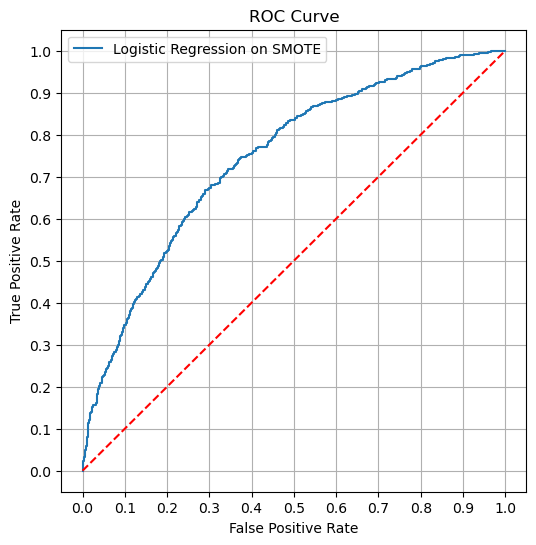

The AUC score is:  0.7443989287864703
The best f1 score is:  0.413265306122449
The best threshold is:  0.5099999999999998


In [34]:
get_outputs("Logistic Regression", y_test, y_pred)
get_best_threshold(y_test, logreg.predict_proba(X_test_logreg)[:,1])
plot_roc_curve(y_test, logreg.predict_proba(X_test_logreg)[:,1], "Logistic Regression on SMOTE")

In [35]:
# get the fpr, tpr, and thresholds for plotting the ROC curve later
fpr_logreg_over, tpr_logreg_over, thresholds_logreg_over = roc_curve(y_test, logreg.predict_proba(X_test_logreg)[:,1])

#### 5.1.2 Fit the model on the orginal data

In [36]:
# drop one level of the X_train
X_train_logreg = X_train.copy()
X_train_logreg.drop(dropped_cols, axis=1, inplace=True)

In [37]:
# try run the same model on the unbalanced dataset
# fit the model to the training data
logreg.fit(X_train_logreg, y_train)
# predict on the test data
y_pred = logreg.predict(X_test_logreg)

The results of Logistic Regression on original data on are: 

              precision    recall  f1-score   support

           0       0.84      1.00      0.92      2924
           1       0.00      0.00      0.00       543

    accuracy                           0.84      3467
   macro avg       0.42      0.50      0.46      3467
weighted avg       0.71      0.84      0.77      3467

The confusion matrix is: 
 [[2924    0]
 [ 543    0]]
The recall score is:  0.0
The accuracy score is:  0.8433804441880588
The specificity score is:  1.0
The precision score is:  0.0
The f1 score is:  0.0 

The matthews correlation coefficient is:  0.0
The best f1 score is:  0.032432432432432434
The best threshold is:  0.1


/Users/panpeter/opt/anaconda3/envs/torch_py3_8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/panpeter/opt/anaconda3/envs/torch_py3_8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/panpeter/opt/anaconda3/envs/torch_py3_8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

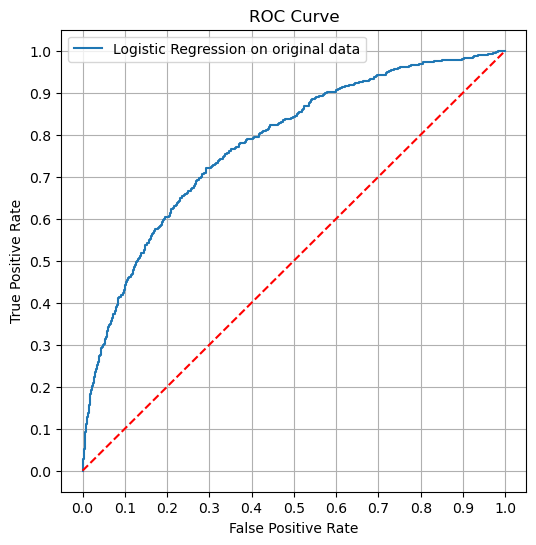

The AUC score is:  0.7779700856315801
The best f1 score is:  0.032432432432432434
The best threshold is:  0.1


In [38]:
get_outputs("Logistic Regression on original data", y_test, y_pred)
get_best_threshold(y_test, logreg.predict_proba(X_test_logreg)[:,1])
plot_roc_curve(y_test, logreg.predict_proba(X_test_logreg)[:,1], "Logistic Regression on original data")

In [39]:
# get the fpr, tpr, and thresholds for plotting the ROC curve later
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, logreg.predict_proba(X_test_logreg)[:,1])

In [40]:
# merge the fpr_logreg, tpr_logreg, thresholds_logreg, fpr_logreg_over, tpr_logreg_over, thresholds_logreg_over
# into a dataframe
# logreg_roc = pd.DataFrame({'fpr_logreg':fpr_logreg, 'tpr_logreg':tpr_logreg, 'thresholds_logreg':thresholds_logreg})
# save the dataframe to csv file
# logreg_roc.to_csv('/Users/panpeter/Desktop/PhD_Learning/Independent Studies/dropout/03_outputs/02_tables/09_logreg_roc.csv', index=False)

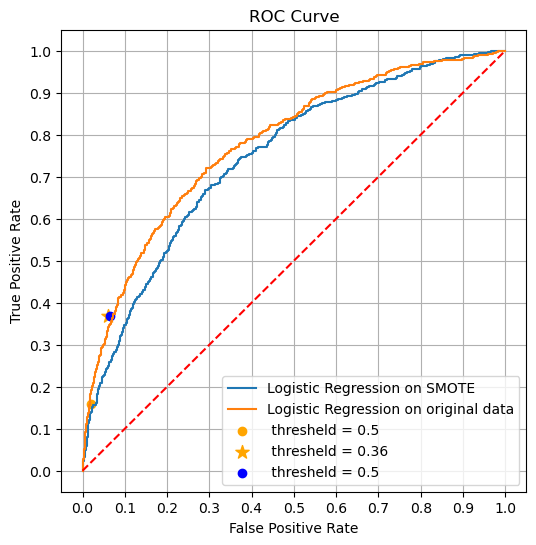

In [41]:
# plot the two ROC curves together
plt.figure(figsize=(6, 6))
plt.plot(fpr_logreg_over, tpr_logreg_over, label="Logistic Regression on SMOTE")
plt.plot(fpr_logreg, tpr_logreg, label="Logistic Regression on original data")
# plot the point [0.017,0.122] on the ROC curve with the same color above
plt.scatter(1-0.981,0.16, color='orange',label=' thresheld = 0.5')
# plot another point 0.187,0.562 with different shape
plt.scatter(0.06053351573187420,0.3683241252302030, color='orange', marker="*",s=100,label=' thresheld = 0.36')
plt.scatter(1-0.934,0.368, color='blue', label=' thresheld = 0.5')
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plot the x and y interval 0.1
plt.grid()
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("ROC Curve")
plt.legend(loc='best')
plt.show()

### 5.2 Random Forest

#### 5.2.1 Fit the model on the original dataset

In [42]:
# run random forest model
# define the model
rf = RandomForestClassifier(random_state=42)
# fit the model to the training data
rf.fit(X_train, y_train)
# predict on the test data
y_pred = rf.predict(X_test)

In [43]:
# get the feature importance
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': rf.feature_importances_})
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance.head(10)

,feature,importance
5,X1TXMTSCOR,0.084466
1,X1SESU,0.078677
16,X1PROBLEM,0.062282
2,X1SCHOOLENG,0.062161
17,S1MSCORE,0.062118
4,X1SCHOOLCLI,0.062070
3,X1SCHOOLBEL,0.060536
14,X1PAREDEXPCT,0.056994
13,X1SCIINT,0.053171
9,X1MTHINT,0.052132


In [44]:
# get the outputs
get_outputs("Random Forest", y_test, y_pred)
get_best_threshold(y_test, rf.predict_proba(X_test)[:,1])

The results of Random Forest on are: 

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      2924
           1       0.57      0.15      0.24       543

    accuracy                           0.85      3467
   macro avg       0.72      0.57      0.58      3467
weighted avg       0.82      0.85      0.81      3467

The confusion matrix is: 
 [[2862   62]
 [ 460   83]]
The recall score is:  0.15285451197053407
The accuracy score is:  0.8494375540813384
The specificity score is:  0.978796169630643
The precision score is:  0.5724137931034483
The f1 score is:  0.24127906976744187 

The matthews correlation coefficient is:  0.2390165072186688
The best f1 score is:  0.47598253275109176
The best threshold is:  0.23999999999999994


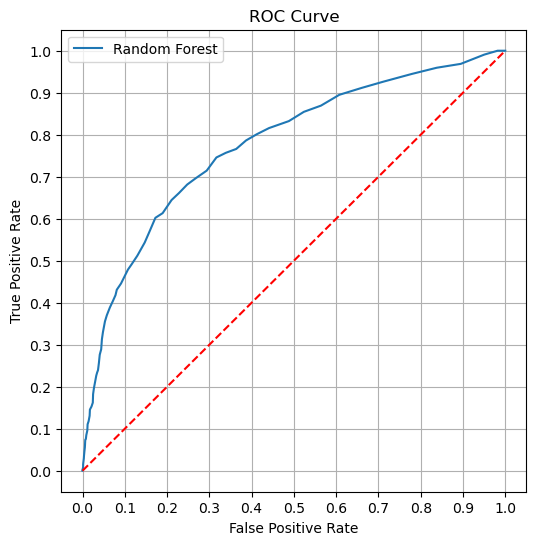

The AUC score is:  0.7764531419660246
The best f1 score is:  0.47598253275109176
The best threshold is:  0.23999999999999994


In [45]:
# using plt function to plot the ROC curve in the figure size (6,6) with x-y axis interval of 0.1 and grid line
plot_roc_curve(y_test, rf.predict_proba(X_test)[:,1], "Random Forest")

In [46]:
# get the fpr, tpr, and thresholds for plotting the ROC curve later
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:,1])

#### 5.2.2 Fit the model on the oversampled data

In [47]:
# fit the model to the oversampled training data
rf.fit(X_train_blsm, y_train_blsm)
# predict on the test data
y_pred = rf.predict(X_test)

In [48]:
# get the feature importance
feature_importance = pd.DataFrame({'feature': X_train_blsm.columns, 'importance': rf.feature_importances_})
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance.head(20)

,feature,importance
17,S1MSCORE,0.126656
5,X1TXMTSCOR,0.086827
1,X1SESU,0.076268
14,X1PAREDEXPCT,0.062421
2,X1SCHOOLENG,0.056761
16,X1PROBLEM,0.052933
3,X1SCHOOLBEL,0.046766
4,X1SCHOOLCLI,0.042890
10,X1SCIID,0.037777
8,X1MTHEFF,0.037450


The results of Random Forest on are: 

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2924
           1       0.47      0.28      0.35       543

    accuracy                           0.84      3467
   macro avg       0.67      0.61      0.63      3467
weighted avg       0.81      0.84      0.82      3467

The confusion matrix is: 
 [[2747  177]
 [ 389  154]]
The recall score is:  0.283609576427256
The accuracy score is:  0.8367464666858956
The specificity score is:  0.9394664842681258
The precision score is:  0.4652567975830816
The f1 score is:  0.3524027459954233 

The matthews correlation coefficient is:  0.27589227584953735
The best f1 score is:  0.44339622641509435
The best threshold is:  0.3899999999999999


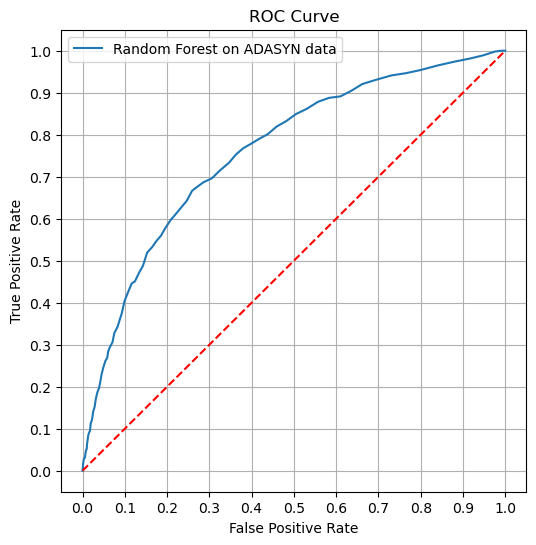

The AUC score is:  0.7611224690312975
The best f1 score is:  0.44339622641509435
The best threshold is:  0.3899999999999999


In [49]:
# get the outputs
get_outputs("Random Forest", y_test, y_pred)
get_best_threshold(y_test, rf.predict_proba(X_test)[:,1])
plot_roc_curve(y_test, rf.predict_proba(X_test)[:,1], "Random Forest on ADASYN data")

#### 5.2.3 Tuning the paramters on the orginal and oversampled dataset

2024.01.04  
Comment the following code chunk and use the tuned parameters directly as last time to save time.

In [50]:
'''
# tuning the hyperparameters of the random forest model using random search on the original dataset
# define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
# define the model
rf = RandomForestClassifier(random_state=42)
# define the grid search
grid_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, cv=3, n_iter=100, scoring='recall', n_jobs=-1, verbose=1, random_state=42)
# fit the grid search to the training data
grid_search.fit(X_train, y_train)
'''

"\n# tuning the hyperparameters of the random forest model using random search on the original dataset\n# define the parameter grid\nparam_grid = {\n    'n_estimators': [100, 200, 300, 400, 500],\n    'max_depth': [10, 20, 30, 40, 50, None],\n    'min_samples_split': [2, 5, 10],\n    'min_samples_leaf': [1, 2, 4],\n    'bootstrap': [True, False]\n}\n# define the model\nrf = RandomForestClassifier(random_state=42)\n# define the grid search\ngrid_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, cv=3, n_iter=100, scoring='recall', n_jobs=-1, verbose=1, random_state=42)\n# fit the grid search to the training data\ngrid_search.fit(X_train, y_train)\n"

In [51]:
'''
# get the best parameters
grid_search.best_params_
'''

'\n# get the best parameters\ngrid_search.best_params_\n'

In [52]:
# 2024.01.04 directly use the best parameters
# save the best parameters
best_params = {'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 30,
 'bootstrap': False}

In [53]:
# get the best model
best_rf = RandomForestClassifier(**best_params, random_state=42)
# fit the model to the training data
best_rf.fit(X_train, y_train)
# predict on the test data
y_pred = best_rf.predict(X_test)

The results of Random Forest on orginal with best parameters on are: 

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      2924
           1       0.59      0.16      0.25       543

    accuracy                           0.85      3467
   macro avg       0.73      0.57      0.59      3467
weighted avg       0.82      0.85      0.81      3467

The confusion matrix is: 
 [[2864   60]
 [ 455   88]]
The recall score is:  0.16206261510128914
The accuracy score is:  0.8514565907124315
The specificity score is:  0.9794801641586868
The precision score is:  0.5945945945945946
The f1 score is:  0.25470332850940663 

The matthews correlation coefficient is:  0.2544730727761796
The best f1 score is:  0.472636815920398
The best threshold is:  0.2699999999999999


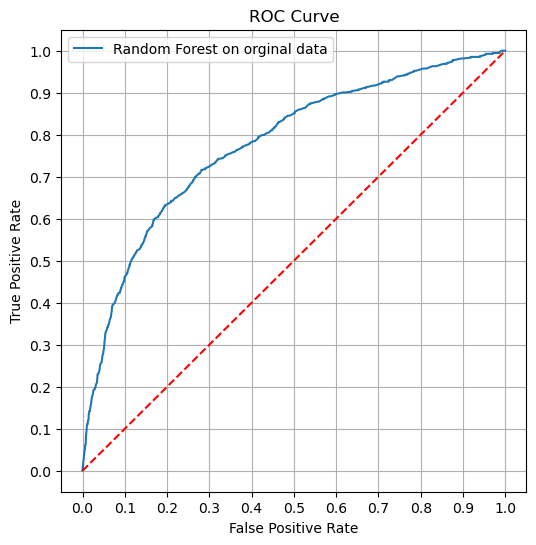

The AUC score is:  0.7766912174094873
The best f1 score is:  0.472636815920398
The best threshold is:  0.2699999999999999


In [54]:
# get the outputs
get_outputs("Random Forest on orginal with best parameters", y_test, y_pred)
get_best_threshold(y_test, best_rf.predict_proba(X_test)[:,1])
plot_roc_curve(y_test, best_rf.predict_proba(X_test)[:,1], "Random Forest on orginal data")

In [55]:
# get the fpr, tpr, and thresholds for plotting the ROC curve later
fpr_rf_best, tpr_rf_best, thresholds_rf_best = roc_curve(y_test, best_rf.predict_proba(X_test)[:,1])

In [56]:
'''
if drop_protected == True:
    # tuning the hyperparameters of the random forest model using random search
    # define the parameter grid
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15],
        'min_samples_leaf': [1, 2, 3],
        'min_samples_split': [2, 3, 4]
    }
    
    # param_grid = {
    #     'max_depth': [100, 140, 180, 220, 260, 300, 340, 380, 420, 460, 500, None],
    #     'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
    #     'max_features': ['sqrt']
    # }
    # define the model
    rf = RandomForestClassifier(random_state=42)
    # define the grid search
    grid_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, cv=3, n_iter=50, scoring='recall', n_jobs=-1, verbose=1, random_state=42)
    # fit the grid search to the training data
    grid_search.fit(X_train_blsm, y_train_blsm)
'''

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [57]:
'''
# get the best parameters
grid_search.best_params_
'''

'\n# get the best parameters\ngrid_search.best_params_\n'

Using the randomizedGrid search, the returned best paramters are  
{'n_estimators': 200,  
'min_samples_split': 4,  
'min_samples_leaf': 2,  
'max_depth': 15}

In [58]:
best_params = {'n_estimators': 200,
     'min_samples_split': 2,
     'min_samples_leaf': 1,
     'max_depth': 15}

In [59]:
# get the best model
# best_rf = grid_search.best_estimator_
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train_blsm, y_train_blsm)
# predict on the test data
y_pred = best_rf.predict(X_test)

The results of Random Forest on SMOTE on are: 

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2924
           1       0.52      0.24      0.32       543

    accuracy                           0.85      3467
   macro avg       0.69      0.60      0.62      3467
weighted avg       0.82      0.85      0.82      3467

The confusion matrix is: 
 [[2804  120]
 [ 415  128]]
The recall score is:  0.23572744014732966
The accuracy score is:  0.8456879146235939
The specificity score is:  0.9589603283173734
The precision score is:  0.5161290322580645
The f1 score is:  0.3236409608091024 

The matthews correlation coefficient is:  0.27456232094869726
The best f1 score is:  0.44839255499153974
The best threshold is:  0.3699999999999999


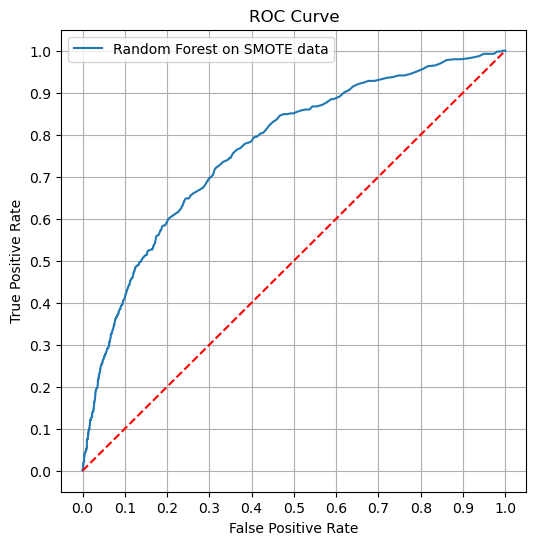

The AUC score is:  0.7661059926990198
The best f1 score is:  0.44839255499153974
The best threshold is:  0.3699999999999999


In [60]:
# get the outputs
get_outputs("Random Forest on SMOTE", y_test, y_pred)
get_best_threshold(y_test, best_rf.predict_proba(X_test)[:,1])
plot_roc_curve(y_test, best_rf.predict_proba(X_test)[:,1], "Random Forest on SMOTE data")

In [61]:
# get the fpr, tpr, and thresholds for plotting the ROC curve later
fpr_rf_best_over, tpr_rf_best_over, thresholds_rf_best_over = roc_curve(y_test, best_rf.predict_proba(X_test)[:,1])

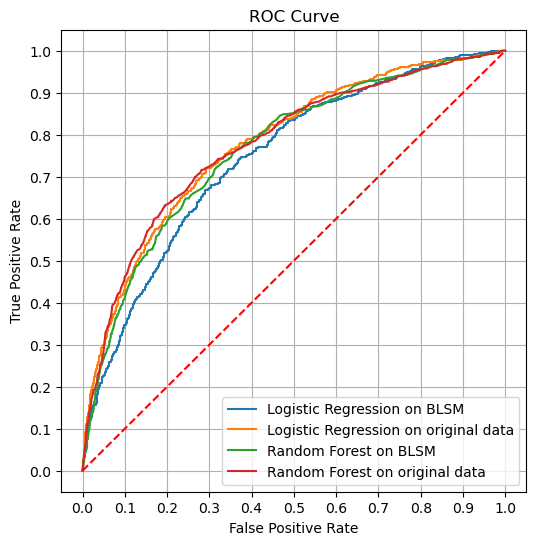

In [62]:
# plot the logistic regression and random forest ROC curves together
plt.figure(figsize=(6, 6))
plt.plot(fpr_logreg_over, tpr_logreg_over, label="Logistic Regression on BLSM")
plt.plot(fpr_logreg, tpr_logreg, label="Logistic Regression on original data")
plt.plot(fpr_rf_best_over, tpr_rf_best_over, label="Random Forest on BLSM")
plt.plot(fpr_rf_best, tpr_rf_best, label="Random Forest on original data")
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plot the x and y interval 0.1
plt.grid()
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("ROC Curve")
plt.legend(loc='best')
plt.show()

### 5.3 XGBoosting Method

#### 5.3.1 Fit the model on the original data

In [63]:
# run XGBoost model
# define the model
xgb = XGBClassifier(random_state=42)
# fit the model to the training data
xgb.fit(X_train, y_train)
# predict on the test data
y_pred = xgb.predict(X_test)

In [64]:
# get the feature importance
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': xgb.feature_importances_})
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance.head(20)

,feature,importance
18,X1CONTROLCatholicorotherprivate,0.138989
14,X1PAREDEXPCT,0.138476
0,X1STAGE,0.101932
17,S1MSCORE,0.055604
23,X1REGIONWest,0.038618
5,X1TXMTSCOR,0.034890
2,X1SCHOOLENG,0.033634
3,X1SCHOOLBEL,0.033181
1,X1SESU,0.032690
15,X1STUEDEXPCT,0.031113


The results of XGBoost on are: 

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2924
           1       0.53      0.22      0.31       543

    accuracy                           0.85      3467
   macro avg       0.70      0.59      0.61      3467
weighted avg       0.82      0.85      0.82      3467

The confusion matrix is: 
 [[2818  106]
 [ 424  119]]
The recall score is:  0.21915285451197053
The accuracy score is:  0.8471300836458033
The specificity score is:  0.9637482900136799
The precision score is:  0.5288888888888889
The f1 score is:  0.3098958333333333 

The matthews correlation coefficient is:  0.26984057757523144
The best f1 score is:  0.43771991555242784
The best threshold is:  0.15999999999999998


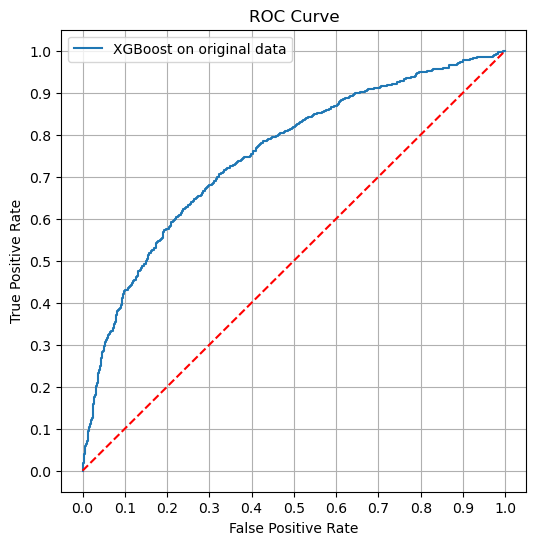

The AUC score is:  0.7508767222679897
The best f1 score is:  0.43771991555242784
The best threshold is:  0.15999999999999998


In [65]:
# get the outputs
get_outputs("XGBoost", y_test, y_pred)
get_best_threshold(y_test, xgb.predict_proba(X_test)[:,1])
plot_roc_curve(y_test, xgb.predict_proba(X_test)[:,1], "XGBoost on original data")

#### 5.3.2 Fit the model on oversampled data

In [66]:
# fit the model to the oversampled training data
xgb.fit(X_train_blsm, y_train_blsm)
# predict on the test data
y_pred = xgb.predict(X_test)

In [67]:
# get the feature importance
feature_importance = pd.DataFrame({'feature': X_train_blsm.columns, 'importance': xgb.feature_importances_})
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance.head(20)

,feature,importance
18,X1CONTROLCatholicorotherprivate,0.197666
23,X1REGIONWest,0.182017
21,X1REGIONNortheast,0.106746
17,S1MSCORE,0.084502
19,X1CONTROLPublic,0.078077
20,X1REGIONMidwest,0.071889
14,X1PAREDEXPCT,0.049959
22,X1REGIONSouth,0.039367
10,X1SCIID,0.028750
6,X1MTHID,0.023085


The results of XGBoost on oversampled data on are: 

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      2924
           1       0.52      0.27      0.36       543

    accuracy                           0.85      3467
   macro avg       0.70      0.61      0.64      3467
weighted avg       0.82      0.85      0.83      3467

The confusion matrix is: 
 [[2785  139]
 [ 394  149]]
The recall score is:  0.27440147329650094
The accuracy score is:  0.8462647822324777
The specificity score is:  0.9524623803009576
The precision score is:  0.5173611111111112
The f1 score is:  0.358604091456077 

The matthews correlation coefficient is:  0.2987530832043261
The best f1 score is:  0.4227174694464414
The best threshold is:  0.20999999999999996


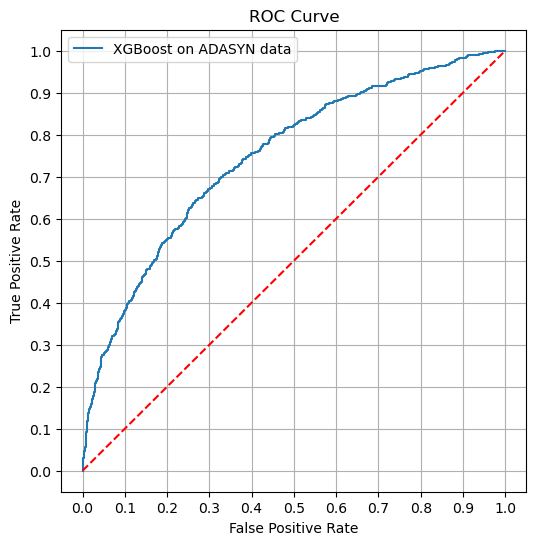

The AUC score is:  0.7474006948275905
The best f1 score is:  0.4227174694464414
The best threshold is:  0.20999999999999996


In [68]:
# get the outputs
get_outputs("XGBoost on oversampled data", y_test, y_pred)
get_best_threshold(y_test, xgb.predict_proba(X_test)[:,1])
plot_roc_curve(y_test, xgb.predict_proba(X_test)[:,1], "XGBoost on ADASYN data")

#### 5.3.3 Tuning the hyperparamters

In [69]:
'''
# tuning the hyperparameters of the XGBoost model using random search
# define the parameter grid
param_grid = {
    'learning_rate': np.arange(0.01, 0.1, 0.01),
    'min_child_weight': range(1, 10, 1),
    'max_depth': range(3, 10, 1),
    'gamma': np.arange(0, 1, 0.1),
    'subsample': np.arange(0.5, 1, 0.1)
}

# Initialize a RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb, param_grid, cv=3, scoring='recall', n_jobs=-1,verbose=1)

# Fit on the training data
random_search.fit(X_train, y_train)

# Get the best parameters
best_params_ori = random_search.best_params_

best_params_ori
'''

"\n# tuning the hyperparameters of the XGBoost model using random search\n# define the parameter grid\nparam_grid = {\n    'learning_rate': np.arange(0.01, 0.1, 0.01),\n    'min_child_weight': range(1, 10, 1),\n    'max_depth': range(3, 10, 1),\n    'gamma': np.arange(0, 1, 0.1),\n    'subsample': np.arange(0.5, 1, 0.1)\n}\n\n# Initialize a RandomizedSearchCV object\nrandom_search = RandomizedSearchCV(xgb, param_grid, cv=3, scoring='recall', n_jobs=-1,verbose=1)\n\n# Fit on the training data\nrandom_search.fit(X_train, y_train)\n\n# Get the best parameters\nbest_params_ori = random_search.best_params_\n\nbest_params_ori\n"

##### 5.3.3.1 The best model trained on the orginal dataset

In [70]:
# 2024.01.04 directly use the best parameters
best_params = {'subsample': 0.6,
 'min_child_weight': 5,
 'max_depth': 7,
 'learning_rate': 0.09,
 'gamma': 0.7000000000000001}

In [71]:
# input the best parameters; the ** operator unpacks the dictionary
xgb_best = XGBClassifier(**best_params, random_state=42)
# fit the model to the training data
xgb_best.fit(X_train, y_train)
# predict on the test data
y_pred = xgb_best.predict(X_test)

The results of XGBoost on orginal data on are: 

              precision    recall  f1-score   support

           0       0.87      0.97      0.91      2924
           1       0.51      0.20      0.28       543

    accuracy                           0.84      3467
   macro avg       0.69      0.58      0.60      3467
weighted avg       0.81      0.84      0.81      3467

The confusion matrix is: 
 [[2822  102]
 [ 436  107]]
The recall score is:  0.19705340699815838
The accuracy score is:  0.8448226132102682
The specificity score is:  0.9651162790697675
The precision score is:  0.5119617224880383
The f1 score is:  0.2845744680851064 

The matthews correlation coefficient is:  0.24763361173706444
The best f1 score is:  0.47237076648841353
The best threshold is:  0.2699999999999999


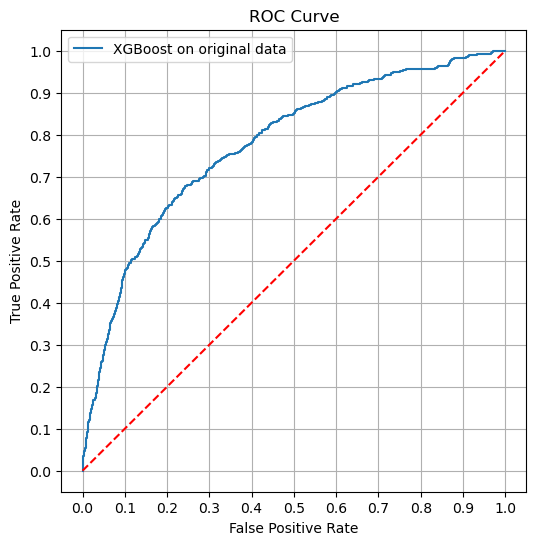

The AUC score is:  0.7767431783197669
The best f1 score is:  0.47237076648841353
The best threshold is:  0.2699999999999999


In [72]:
# get the outputs
get_outputs("XGBoost on orginal data", y_test, y_pred)
get_best_threshold(y_test, xgb_best.predict_proba(X_test)[:,1])
plot_roc_curve(y_test, xgb_best.predict_proba(X_test)[:,1], "XGBoost on original data")

In [73]:
# get the fpr, tpr, and thresholds for plotting the ROC curve later
fpr_xgb_best, tpr_xgb_best, thresholds_xgb_best = roc_curve(y_test, xgb_best.predict_proba(X_test)[:,1])

##### 5.3.3.2 The best model trained on the oversampled dataset

In [74]:
'''
if drop_protected == True:
    # tuning the hyperparameters of the XGBoost model using random search
    # define the parameter grid
    param_grid = {
        'learning_rate': np.arange(0.01, 0.1, 0.01),
        'min_child_weight': range(1, 10, 1),
        'max_depth': range(3, 10, 1),
        'gamma': np.arange(0, 1, 0.1),
        'subsample': np.arange(0.5, 1, 0.1)
    }
    
    # Initialize a RandomizedSearchCV object
    random_search = RandomizedSearchCV(xgb, param_grid, cv=3, scoring='recall', n_jobs=-1,verbose=1)
    
    # Fit on the training data
    random_search.fit(X_train_blsm, y_train_blsm)
    
    # Get the best parameters
    best_params = random_search.best_params_
    
    best_params
'''

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [75]:
# 2024.01.04 directly use the best parameters
best_params = {'subsample': 0.8999999999999999,
     'min_child_weight': 4,
     'max_depth': 7,
     'learning_rate': 0.01,
     'gamma': 0.0}

In [76]:
# input the best parameters; the ** operator unpacks the dictionary
xgb_best = XGBClassifier(**best_params, random_state=42)
# fit the model to the training data
xgb_best.fit(X_train_blsm, y_train_blsm)
# predict on the test data
y_pred = xgb_best.predict(X_test)

The results of XGBoost on blsm data on are: 

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      2924
           1       0.40      0.43      0.41       543

    accuracy                           0.81      3467
   macro avg       0.64      0.65      0.65      3467
weighted avg       0.81      0.81      0.81      3467

The confusion matrix is: 
 [[2568  356]
 [ 310  233]]
The recall score is:  0.429097605893186
The accuracy score is:  0.8079030862417075
The specificity score is:  0.8782489740082079
The precision score is:  0.39558573853989815
The f1 score is:  0.41166077738515905 

The matthews correlation coefficient is:  0.2974499782294886
The best f1 score is:  0.44245142002989535
The best threshold is:  0.44999999999999984


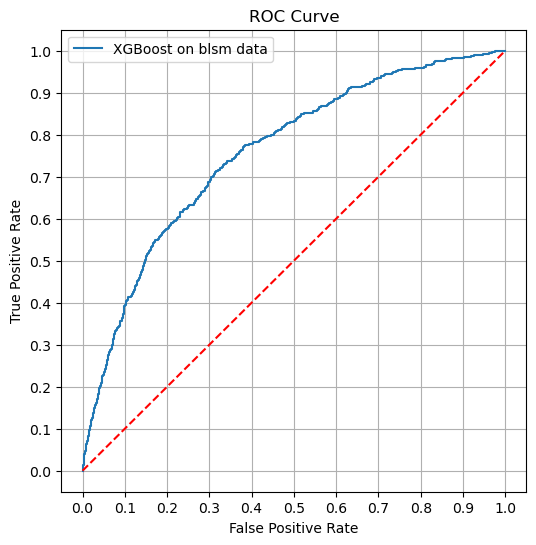

The AUC score is:  0.7573734106259746
The best f1 score is:  0.44245142002989535
The best threshold is:  0.44999999999999984


In [77]:
# get the outputs
get_outputs("XGBoost on blsm data", y_test, y_pred)
get_best_threshold(y_test, xgb_best.predict_proba(X_test)[:,1])
plot_roc_curve(y_test, xgb_best.predict_proba(X_test)[:,1], "XGBoost on blsm data")

In [78]:
# get the fpr, tpr, and thresholds for plotting the ROC curve later
fpr_xgb_best_over, tpr_xgb_best_over, thresholds_xgb_best_over = roc_curve(y_test, xgb_best.predict_proba(X_test)[:,1])

### 5.4 SVM method

#### 5.4.1 SVM on the original dataset

In [79]:
# normalize the numerical features
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

In [80]:
# run SVM method on the training data
# define the model
svm = SVC(random_state=42, probability=True, 
          kernel='linear', C=0.1, gamma='auto',
          class_weight='balanced')
# fit the model to the training data
svm.fit(X_train, y_train)
# predict on the test data
y_pred = svm.predict(X_test)

The results of SVM on are: 

              precision    recall  f1-score   support

           0       0.93      0.72      0.81      2924
           1       0.32      0.72      0.44       543

    accuracy                           0.72      3467
   macro avg       0.63      0.72      0.63      3467
weighted avg       0.84      0.72      0.75      3467

The confusion matrix is: 
 [[2102  822]
 [ 154  389]]
The recall score is:  0.716390423572744
The accuracy score is:  0.7184886068647246
The specificity score is:  0.7188782489740082
The precision score is:  0.3212221304706854
The f1 score is:  0.443557582668187 

The matthews correlation coefficient is:  0.3318213994764962
The best f1 score is:  0.4856687898089172
The best threshold is:  0.23999999999999994


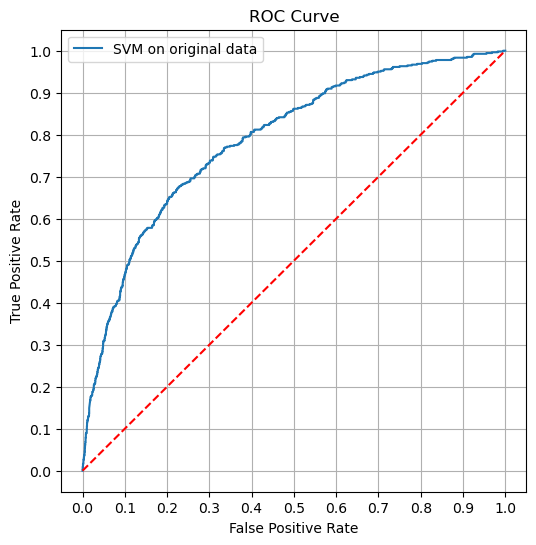

The AUC score is:  0.7890689360672961
The best f1 score is:  0.4856687898089172
The best threshold is:  0.23999999999999994


In [81]:
# get the outputs
get_outputs("SVM", y_test, y_pred)
get_best_threshold(y_test, svm.predict_proba(X_test)[:,1])
plot_roc_curve(y_test, svm.predict_proba(X_test)[:,1], "SVM on original data")

In [82]:
# get the fpr, tpr, and thresholds for plotting the ROC curve later
fpr_svm_best, tpr_svm_best, thresholds_svm_best = roc_curve(y_test, svm.predict_proba(X_test)[:,1])

#### 5.4.2 Tuning the parameters

## 6.0 Comparison

In [83]:
# read the roc curve data
roc_nn = pd.read_csv("/Users/panpeter/Desktop/PhD_Learning/Independent Studies/dropout/03_outputs/02_tables/nn_roc_data.csv")

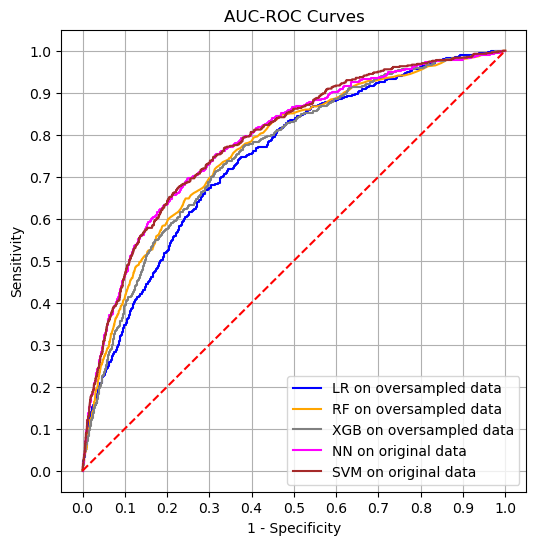

In [84]:
size_ = 300
plt.figure(figsize=(6, 6))
# plot the logistic regression, random forest, and XGboost ROC curves together, and plot the 0.5 threshold point with the same color to the line
plt.plot(fpr_logreg_over, tpr_logreg_over, label="LR on oversampled data", color='blue')
# plot a certain point on the line with label
# plt.scatter(1-0.949, 0.232, color='blue', marker='*',s=size_)
# plt.plot(fpr_logreg, tpr_logreg, label="Logistic Regression on original data", color='green')
# plt.scatter(1-0.981, 0.169, color='green', marker='*', s=size_)
plt.plot(fpr_rf_best_over, tpr_rf_best_over, label="RF on oversampled data",color='orange')
# plt.scatter(1-0.865, 0.414, color='orange', marker='*', s=size_)
# plt.plot(fpr_rf_best, tpr_rf_best, label="Random Forest on original data", color='red')
# plt.scatter(1-0.974, 0.157, color='red', marker='*', s=size_)
plt.plot(fpr_xgb_best_over, tpr_xgb_best_over, label="XGB on oversampled data",color='grey')
# plt.scatter(1-0.788, 0.554, color='grey', marker='*', s=size_)
# plt.plot(fpr_xgb_best, tpr_xgb_best, label="XGBoost on original data", color='brown')
# plt.scatter(1-0.98, 0.162, color='brown', marker='*', s=size_)
plt.plot(roc_nn.fpr_nn, roc_nn.tpr_nn, label="NN on original data", color='magenta')
# plt.scatter(1-0.683, 0.696, color='magenta', marker='*', s=size_)
plt.plot(fpr_svm_best, tpr_svm_best, label="SVM on original data", color='brown')

plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
# plot the x and y interval 0.1
plt.grid()
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("AUC-ROC Curves")
plt.legend(loc='best')
plt.show()